In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 

X = pd.read_parquet("../artifacts/features.parquet")
metadata = pd.read_parquet("../artifacts/metadata.parquet")

print(f"X shape: {X.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)


X shape: (50878, 36)


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.0
  Silhouette: 0.241, DB: 1.162


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 24 with accuracies 
[1.57044514e-12 9.35205549e-07 6.25761130e-07 5.40802456e-08
 5.82667755e-07]
not reaching the requested tolerance 7.450580596923828e-07.
Use iteration 24 instead with accuracy 
4.395432500282267e-07.

  _, diffusion_map = lobpcg(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[6.84637985e-14 9.35206026e-07 6.25760424e-07 5.40802348e-08
 5.82667748e-07]
not reaching the requested tolerance 7.450580596923828e-07.
  _, diffusion_map = lobpcg(


n_neighbors=30, min_dist=0.1
  Silhouette: 0.258, DB: 1.085


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.25
  Silhouette: 0.290, DB: 1.036


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.5
  Silhouette: 0.318, DB: 1.033


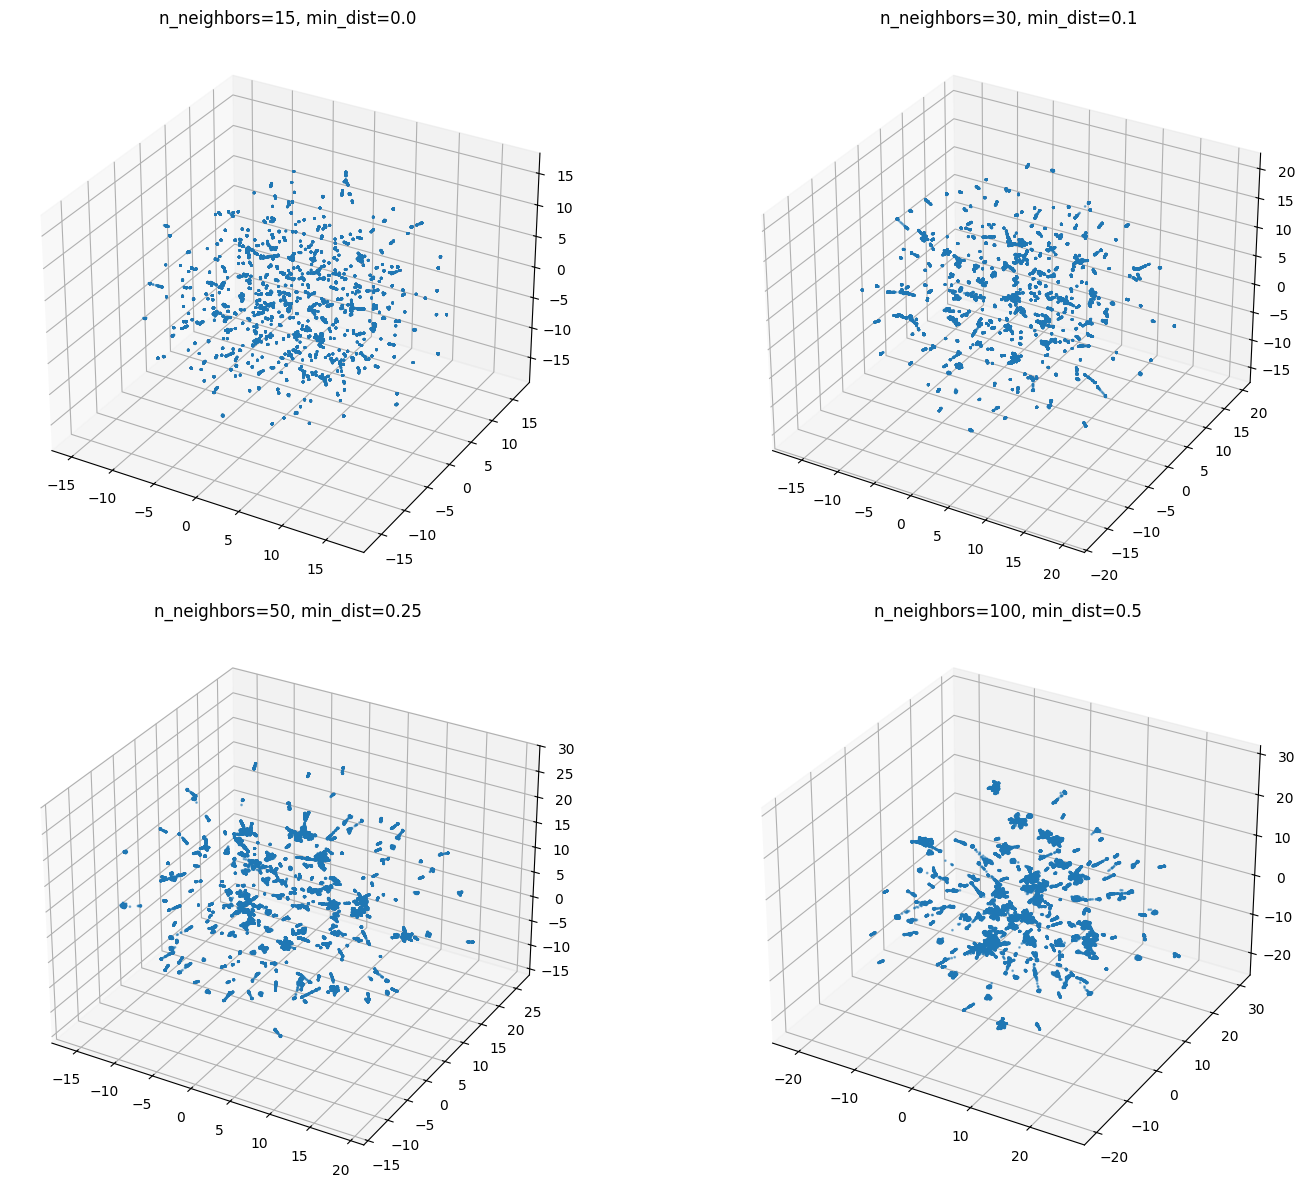

In [5]:
# lets try some different hyperparameters for UMAP and see which ones look the best

# few different combos for hyperparameters 
configs = [
    {'n_neighbors': 15, 'min_dist': 0.0},
    {'n_neighbors': 30, 'min_dist': 0.1},
    {'n_neighbors': 50, 'min_dist': 0.25},
    {'n_neighbors': 100, 'min_dist': 0.5},
]

results=[]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

fig = plt.figure(figsize=(16, 12))

for i, config in enumerate(configs, 1):
    reducer = umap.UMAP(
        n_components=3,
        n_neighbors=config['n_neighbors'],
        min_dist=config['min_dist'],
        random_state=42
    )
    
    embedding = reducer.fit_transform(X_pca)

    kmeans = KMeans(n_clusters = 10, random_state=42)
    labels = kmeans.fit_predict(embedding)

    # Calculate metrics
    silhouette = silhouette_score(embedding, labels)
    db_score = davies_bouldin_score(embedding, labels)

    results.append((silhouette, db_score))

    print(f"n_neighbors={config['n_neighbors']}, min_dist={config['min_dist']}")
    print(f"  Silhouette: {silhouette:.3f}, DB: {db_score:.3f}")
    
    ax = fig.add_subplot(2, 2, i, projection='3d')
    ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], 
               s=1, alpha=0.5)
    ax.set_title(f"n_neighbors={config['n_neighbors']}, min_dist={config['min_dist']}")

plt.tight_layout()
plt.show()



In [ ]:

# testing more params using metrics 
param_grid = {
    'n_neighbors': [15, 30, 50, 100, 200],
    'min_dist': [0.0, 0.1, 0.25, 0.5, 0.75],
    'metric': ['euclidean', 'cosine', 'correlation']
}

results = []

for n_neighbors in param_grid['n_neighbors']:
    for min_dist in param_grid['min_dist']:
        for metric in param_grid['metric']:
            
            # Fit UMAP
            reducer = umap.UMAP(
                n_components=3,
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                metric=metric,
                random_state=42
            )
            
            embedding = reducer.fit_transform(X_pca)
            
            # Evaluate with clustering metrics
            # (You need to cluster first - use quick K-means)
            from sklearn.cluster import KMeans
            kmeans = KMeans(n_clusters=10, random_state=42)
            labels = kmeans.fit_predict(embedding)
            
            # Calculate metrics
            silhouette = silhouette_score(embedding, labels)
            db_score = davies_bouldin_score(embedding, labels)
            
            results.append({
                'n_neighbors': n_neighbors,
                'min_dist': min_dist,
                'metric': metric,
                'silhouette': silhouette,
                'davies_bouldin': db_score
            })
            
            print(f"n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}")
            print(f"  Silhouette: {silhouette:.3f}, DB: {db_score:.3f}")

# Convert to DataFrame and find best
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('silhouette', ascending=False)

print("\nTop 5 configurations:")
print(results_df.head())

# Best params
best = results_df.iloc[0]
print(f"\nBest params: n_neighbors={best['n_neighbors']}, min_dist={best['min_dist']}, metric={best['metric']}")
